# Oil well detector

In [1]:
import rasterio as rio
from matplotlib import pyplot as plt
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.plot import show
from rasterio import features
from shapely.geometry import Point, box
import geopandas as gpd
from IPython.display import Image
import numpy as np

Detections oil wells in the Bakken oil field based on satellite imagery

For this project, I will be training an image recognition algorithm to recognize if a pixel is part of an oil well. I will be analyzing various types of satellite images to conduct this analysis.

An example of what these oil well look like is shown below (which for some reason I haven't yet figure out how to show the image in markdown text...)
<img src='Non-images/notebook-images/Oil-well-example.png'>

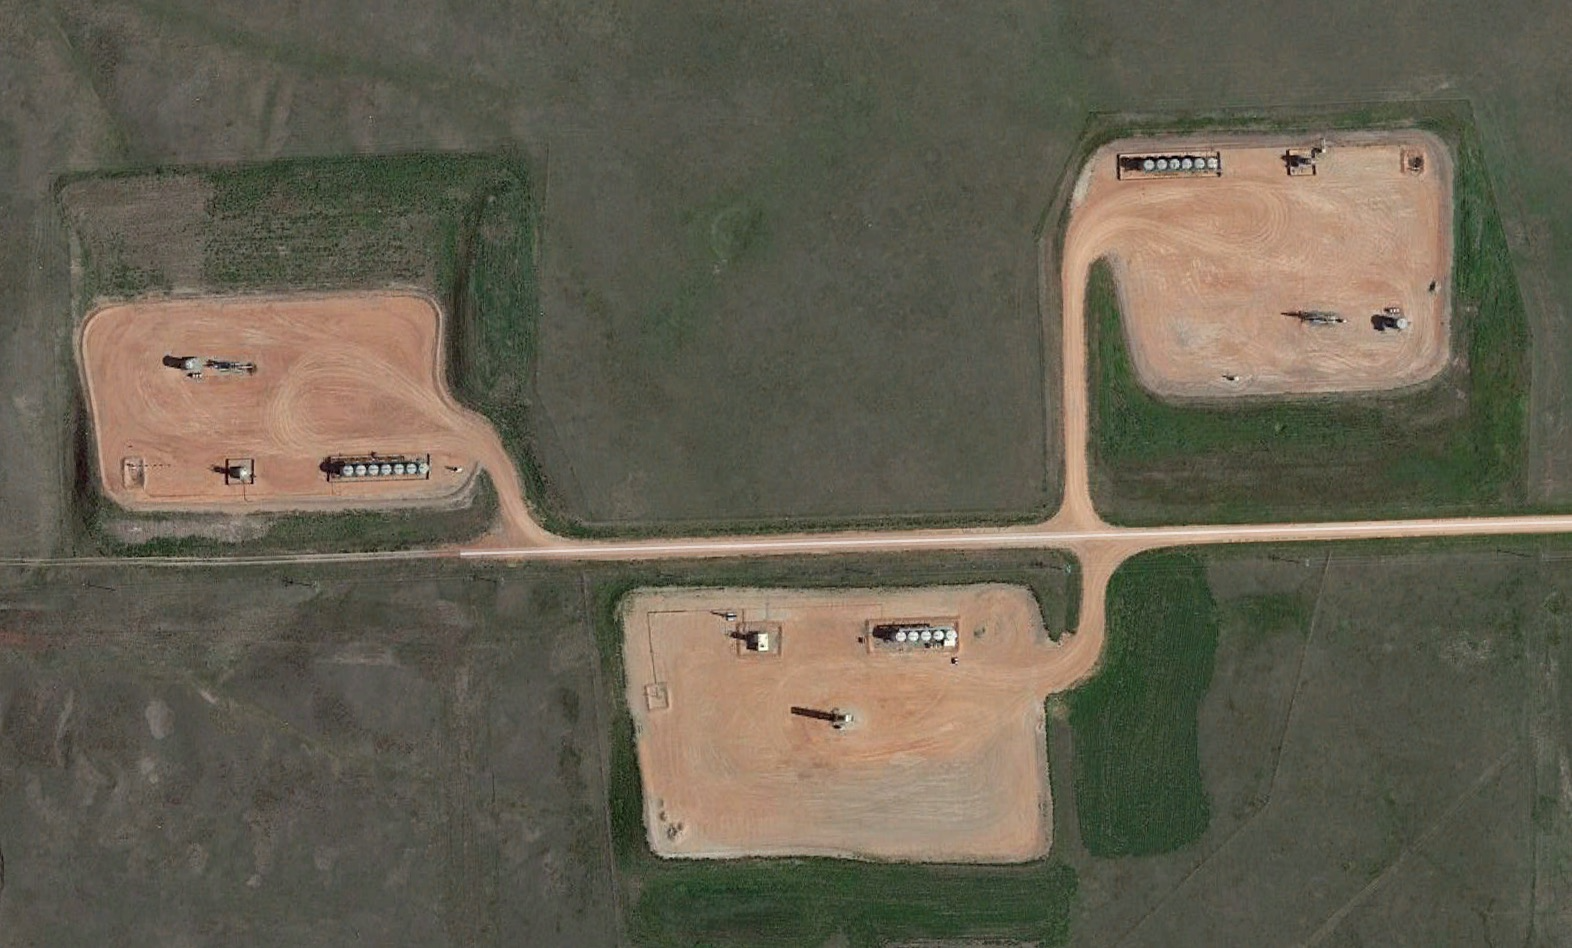

In [3]:
Image(filename='Non_images/notebook_images/Oil-well-example.png')

The image above shows three separate oil wells. 

## Future Work

I am still working on this project. So far I have:

 - downloaded the relevant satelittle images (the raw images are too big to be in a github repo)
 - utilized Rasterio and Shapely analyze the features of the image and crop an area of interest

Still to come I need to:
 - Create the training data
     - make outline examples of oil wells in polygons using Google Earth
     - convert those polygon outlines into a raster image with positive values (1) inside the polygon and zero values outside of the polygon
 - write the neural network that will be trained on the training data
 - compare the performance of a full-connected neural network with a convolutional neural network in predicting if a given pixel will be part of an oil well.

Improvements:
 - download the images direclty from a cloud service like AWS as discussed here - https://geohackweek.github.io/raster/04-workingwithrasters/
 
 
As a reminder to myself, I am currently working on: 
 - Creating template raster to burn the well polygons from Google earth to so I can create a raster version.
 
Mistakes
 - Not ensuring the data has the same CRS is a HUGE mistake. Spent hours figuring that one out....

## Importing and cropping the image file

This file has been downloaded from an imaging site. In the future, I will download it directly from AWS or Google Cloud.

In [5]:
#opening the raster file
im1 = '/Users/dustin/CS/Projects/oil_well_detector/sat_images/T13UFP_20190606T174919_B03.jp2'
satdat = rio.open(im1)

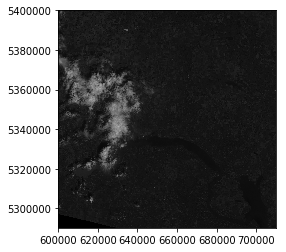

In [6]:
#show the image
show(satdat, cmap='gray')

You can't see much in the image above because the brightness of the cloud makes everything else dark. The axes values are in the projected units of the image. Let's look deeper into the attributes of the image.

### Image Information

In [7]:
print('Image details in projected units')

print('Bounding box: ', satdat.bounds)
print("Width : {}".format(satdat.bounds.right - satdat.bounds.left))
print("Height: {}".format(satdat.bounds.top - satdat.bounds.bottom))
print('Image details in pixel units. Rows: {}, Columns: {}'.format(satdat.height, satdat.width))

Image details in projected units
Bounding box:  BoundingBox(left=600000.0, bottom=5290200.0, right=709800.0, top=5400000.0)
Width : 109800.0
Height: 109800.0
Image details in pixel units. Rows: 10980, Columns: 10980


In [8]:
print('Size of each pixel in projected units (meters in this case)')

#Calculating the size of each pixel in projected units
xres = (satdat.bounds.right - satdat.bounds.left) / satdat.width
yres = (satdat.bounds.top - satdat.bounds.bottom) / satdat.height
print("Column pixel size: {} m, Row pixel size: {} m"
      .format(xres, yres))
print("Are the pixels square: {}".format(xres == yres))

Size of each pixel in projected units (meters in this case)
Column pixel size: 10.0 m, Row pixel size: 10.0 m
Are the pixels square: True


In [9]:
print('The CRS of the image is {}'.format(satdat.crs))
print('The metadata for the image is: {}: '.format(satdat.meta))

The CRS of the image is EPSG:32613
The metadata for the image is: {'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 5400000.0)}: 


In [10]:
# Upper left pixel
up_left = (0,0)

# Lower right pixel.  Rows and columns are zero indexing.
down_right = (satdat.height - 1, satdat.width - 1)

print("Top left corner coordinates: {}".format(satdat.transform*up_left))
print("Bottom right corner coordinates: {}".format(satdat.transform*down_right))

Top left corner coordinates: (600000.0, 5400000.0)
Bottom right corner coordinates: (709790.0, 5290210.0)


In [11]:
#To explore the attributes of the rasterio object check the .__dir__() attribute table
#print(satdat.__dir__())

In [12]:
#converts to numpy array
img = satdat.read().squeeze()

print('Number of bands: ', satdat.count)
print('Number of indexes: ', satdat.indexes) #doesn't exist for single band
print('Number of dimentions: ', img.ndim)
print('Data type: ', img.dtype)
print('Object type: ', type(img))
print('Shape: ', img.shape)

##bad idea, image is too big to generate historgram
##plt.hist(img, bins = [0,20,40,60,80,100]) 
##plt.title("histogram") 
##plt.show()


Number of bands:  1
Number of indexes:  (1,)
Number of dimentions:  2
Data type:  uint16
Object type:  <class 'numpy.ndarray'>
Shape:  (10980, 10980)


### Cropping the image file 

The image file is a bit too big for what I want to focus on, so I have cropping it based on the coordinates specified below.

In [13]:
#the cropping area of interest in WGS84 coordinates
minx, miny =   47.754309, -103.295
maxx, maxy =  47.865643, -103.030516 

bbox = box(minx, miny, maxx, maxy)

#creating a geopandas dataframe of the bounding box for the crop
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=4326)

#reprojecting into the raster image coordinate system - epsg:32613
geo_proj = geo.to_crs(epsg=32613)
geo_proj

,geometry
0,"POLYGON ((627513.363454998 5302774.335855264, ..."


In [17]:
#cropping the raster image
out_img, out_transform = mask(satdat, shapes=geo_proj.geometry, crop=True)
out_transform

Affine(10.0, 0.0, 627510.0,
       0.0, -10.0, 5303250.0)

In [18]:
out_img.dtype

dtype('uint16')

In [19]:
#modify the cropped image's metadata
out_meta = satdat.meta.copy()
#parse the EPSG code
epsg_code = int(satdat.crs.data['init'][5:])
print(epsg_code)

out_meta.update({"driver": "JP2OpenJPEG", 
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform} )
out_meta

32613


{'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'nodata': None,
 'width': 2010,
 'height': 1285,
 'count': 1,
 'crs': CRS.from_epsg(32613),
 'transform': Affine(10.0, 0.0, 627510.0,
        0.0, -10.0, 5303250.0)}

In [22]:
#write the cropped raster

out_jp2 = '/Users/dustin/CS/Projects/oil_well_detector/sat_images/T13UFP_B03_crop.jp2'
with rio.open(out_jp2, "w", **out_meta) as dest:
    dest.write(out_img)

## Creating the training data

After creating the area of interest, we must construct the y-labels which will tell whether a given pixel is inside an oil well. The creation of these y-labels will be done by drawing polygons around oil wells in Google Earth and then converting these polygons into a raster image so that the pixels that are contained in an oil well will have an on label (1) and those pixels outside the oil well will have an off label (0).

In [40]:
well_polygons = gpd.read_file(r'/Users/dustin/CS/projects/oil_well_detector/non_images/training_data/Wells_polygon_93_20190808.gpkg')
well_polygons.crs


{'init': 'epsg:4326'}

In [41]:
#we need to project the polygons that outline the wells into the CRS of the cropped image
well_proj = well_polygons.to_crs(epsg=32613)
well_proj.crs

{'init': 'epsg:32613', 'no_defs': True}

Now the polygons need to be burned to a raster. I need to create a template raster to burn the polygons to. 

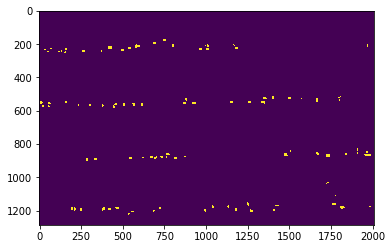

16885
(1285, 2010)


In [42]:
#Burning the polygon layers into a raster file

out_fn = '/Users/dustin/CS/Projects/oil_well_detector/sat_images/well_labels.jp2'

rst_fn = '/Users/dustin/CS/Projects/oil_well_detector/sat_images/T13UFP_B03_crop.tif'
rst = rio.open(rst_fn)
meta = rst.meta.copy()
meta.update(compress='lzw')

with rio.open(out_fn, 'w', **meta) as out:
    
    #we create a generator of geom, value pairs to use in the features.rasterize function
    shapes = ((feature['geometry'], 1) for feature in well_proj.iterfeatures())
    
    burned = features.rasterize(shapes=shapes, out_shape=out_img[0].shape, transform=meta['transform'], fill=0, dtype='uint16', all_touched=False)    
#    out.write_band(1, burned)
    out.write(burned, indexes=1)
show(burned)
print(np.sum(burned))
print(burned.shape)

## Creating the machine learning algorithm

Now, the fun part. The input values of the training data - X values - have been created by cropping the satellite image and the labels of the training data - Y values - have been created by converting the polygons outlining the wells into a raster image. We can now use the input X's and labeled Y's to train a machine learning algorithm to predict whether or not a given pixel is part of an oil well. 

# Scratch

Notes:
W103.388 to W103.028

N47.8548 to N47.755


To do
     - stitch raster’s together
        • use buffer around points to cut out raster images of well sites to make y=1 values
    -  make make cutouts of other imagees for y = 0 values - keeping them all the same size
        • split into training and dev sites
    - train algorithm with just one band
    - take new images and cut them up with standard sizing and use a steping window to perform detection

In [23]:
def importImages(filenames):
    
    #imports the images

    satdat_list = []
    for  i in filenames:
        satdat = rio.open(i)
        satdat_list.append(satdat)
    
    return satdat_list


In [24]:
def changeCRS():
    #set or change the CRS of an image. Not sure if I need this
    
    pass

In [25]:
def file_merge(files, )
    '''
    Description:
    Takes a list of image paths as input and merges all of the images
    into a single file
    
    Input:
    files -- a list of pathnames of the different images
    '''
        
    merge_files= [file1, file2]
    rio_files = []
    out_fp = '/Users/dustin/CS/Projects/Well_identification/Images/mosaic.tif'


    for i in merge_files:
        src = rio.open(i)
        rio_files.append(src)
        
    mosaic, out_trans = merge(rio_files)

SyntaxError: invalid syntax (<ipython-input-25-1a7d124851f9>, line 1)

In [ ]:
def addBuffer(size, filename):
    '''
    Description: 
    Adds a buffer of size size
    
    Input:
    buffer size -- the size of the buffer in who knows what units
    filename  -- a string of the img pathname
    
    Output: 
    
    
    
    '''
    
    gdf = gpd.read_file(r'/Users/dustin/CS/Projects/Well_identification/well-sites.gpkg', layer='well-sites')

    buf = gdf.geometry.buffer(size)
    
    sq_buf = buf.envelope
    
    sq_buf.to_file("sq_buffer.shp")
    
    return  buff

In [ ]:
#writing the mosaic'ed file 
with rio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

In [ ]:
#non-functional rasterize code - don't think it's Python
gdal_rasterize -burn 255 -l tessellate well_polygons.gpkg work.tif